In [39]:
import nltk
from nltk.corpus import brown
from collections import defaultdict, Counter
import numpy as np
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [59]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [60]:
dataset = list(brown.tagged_sents(tagset='universal'))

In [61]:
def preprocess_sentence(sentence, lowercase=True):
    if lowercase:
        return [(word.lower(), tag) for word, tag in sentence]
    else:
        return sentence

dataset = [preprocess_sentence(sentence) for sentence in dataset]

In [43]:
class Viterbi:

    # tags contain the name of all possible tags
    # initial_probs is basically the probab of going from ^ to the word
    # emission_probs are the P(word|tags)
    def __init__(self, tags, initial_probs, transition_probs, emission_probs):

        self.tags = tags
        self.initial_probs = initial_probs
        self.transition_probs = transition_probs
        self.emission_probs = emission_probs

    def viterbi(self, sentence):
        prob_table = [{}]  # This is like a table which stores all the probablities
        path = {} # This dictionary will store good paths only.

        #This loop is only for the first word of the sentence.
        #here a path is created for all possible initial tags
        for tag in self.tags:
            prob_table[0][tag] = self.initial_probs.get(tag, 1e-7) * self.emission_probs.get(tag, {}).get(sentence[0], 1e-7)
            path[tag] = [tag]  # Initialize the path with the starting tag

        #Now we will calculate the paths for each word and will prune the tree suitably.
        #basically we will calculate that for a current tag what sequence of previous tag is the most probable.
        for t in range(1, len(sentence)):
            prob_table.append({})
            new_path = {}

            for curr_tag in self.tags:
                best_prob = -1
                best_prev_tag = None

                # Find the best previous tag
                for prev_tag in self.tags:
                    prob = (prob_table[t-1].get(prev_tag, 1e-7) *
                            self.transition_probs.get(prev_tag, {}).get(curr_tag, 1e-7) *
                            self.emission_probs.get(curr_tag, {}).get(sentence[t], 1e-7))

                    if prob > best_prob:
                        best_prob = prob
                        best_prev_tag = prev_tag

                # Update the probability table and new paths
                prob_table[t][curr_tag] = best_prob
                new_path[curr_tag] = path[best_prev_tag] + [curr_tag]

            path = new_path

        #finding the best final tag
        best_prob = -1
        best_last_tag = None

        for tag in self.tags:
            prob = prob_table[len(sentence) - 1].get(tag, 1e-7)
            if prob > best_prob:
                best_prob = prob
                best_last_tag = tag

        return path[best_last_tag]

In [44]:
def create_int_defaultdict():
    return defaultdict(int)

def create_float_defaultdict():
    return defaultdict(float)

In [45]:
class HiddenMarkovModel:

    def train(self, train_data):

        transition_probs = defaultdict(create_float_defaultdict)
        emission_probs = defaultdict(create_float_defaultdict)
        initial_probs = defaultdict(float)
        tags = set()
        vocabulary = set()

        tag_bigrams = Counter()
        tag_unigrams = Counter()
        word_tag_pairs = Counter()
        tag_starts = Counter()

        for sentence in train_data:

            prev_tag = None

            for word, tag in sentence:

                vocabulary.add(word)
                tags.add(tag)
                tag_unigrams[tag] += 1
                word_tag_pairs[(word, tag)] += 1

                if prev_tag is None:
                    tag_starts[tag] += 1
                else:
                    tag_bigrams[(prev_tag, tag)] += 1

                prev_tag = tag

        total_sentences = len(train_data)

        for tag in tags:
            initial_probs[tag] = tag_starts[tag] / total_sentences

        for (prev_tag, curr_tag), count in tag_bigrams.items():
            transition_probs[prev_tag][curr_tag] = count / tag_unigrams[prev_tag]

        for (word, tag), count in word_tag_pairs.items():
            emission_probs[tag][word] = count / tag_unigrams[tag]

        self.viterbi = Viterbi(tags, initial_probs, transition_probs, emission_probs)

    def predict(self, sentence):

        return self.viterbi.viterbi(sentence)

    def save(self, filename = 'model.pkl'):

        with open(filename, 'wb') as out:
            pickle.dump(self.viterbi, out, pickle.HIGHEST_PROTOCOL)

    def load(self, filename = 'model.pkl'):

        with open(filename, 'rb') as inp:
            self.viterbi = pickle.load(inp)

In [100]:
from sklearn.metrics import precision_recall_fscore_support

class Evaluation:

    def __init__(self):

        self.accuracy = []
        self.confusion_matrix = defaultdict(create_int_defaultdict)
        self.accuracy_per_tag = defaultdict(list)

    def cross_validate(self, data, n=5):

        k_fold = KFold(n_splits=n, shuffle=True, random_state=26)

        for train_i, test_i in k_fold.split(data):

            train_data = [data[i] for i in train_i]
            test_data = [data[i] for i in test_i]
            pos_tagger = HiddenMarkovModel()
            pos_tagger.train(train_data)
            correct_tagged = 0
            total = 0

            for i in test_data:

                words = [word for word, tag in i]
                correct_tags = [tag for word, tag in i]
                predicted_tags = pos_tagger.predict(words)

                for correct_tag, predicted_tag in zip(correct_tags, predicted_tags):

                    if correct_tag == predicted_tag:
                        correct_tagged += 1
                    self.confusion_matrix[correct_tag][predicted_tag] += 1
                    self.accuracy_per_tag[correct_tag].append(correct_tag == predicted_tag)
                    total += 1

                self.accuracy.append(correct_tagged/total)

        return np.mean(self.accuracy)

    def test_eval(self, data, model):
        correct_tagged = 0
        total = 0
        for i in data:
            words = [word for word, tag in i]
            correct_tags = [tag for word, tag in i]
            predicted_tags = model.predict(words)
            for correct_tag, predicted_tag in zip(correct_tags, predicted_tags):
                if correct_tag == predicted_tag:
                    correct_tagged += 1
                self.confusion_matrix[correct_tag][predicted_tag] += 1
                self.accuracy_per_tag[correct_tag].append(correct_tag == predicted_tag)
                total += 1
            self.accuracy.append(correct_tagged/total)

        return np.mean(self.accuracy)

    def plot_eval(self):

        tags = sorted(self.confusion_matrix.keys())
        matrix = np.array([[self.confusion_matrix[true_tag][predicted_tag] for predicted_tag in tags] for true_tag in tags])

        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix, annot=True, fmt="d", xticklabels=tags, yticklabels=tags)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()
        plt.savefig("confusion_matrix_plot.png")

        tag_accuracies = {tag: np.mean(accuracies) for tag, accuracies in self.accuracy_per_tag.items()}

        for tag, accuracy in tag_accuracies.items():
            print(f"Accuracy for {tag}: {accuracy:.2f}")

        return tag_accuracies

    def compute_f1(self):
        tags = sorted(self.confusion_matrix.keys())

        # Extracting true labels and predicted labels
        y_true, y_pred = [], []
        for true_tag in tags:
            for predicted_tag in tags:
                count = self.confusion_matrix[true_tag][predicted_tag]
                y_true.extend([true_tag] * count)
                y_pred.extend([predicted_tag] * count)

        # Calculating precision, recall, f1 score
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=tags, average='macro')

        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")

        return precision, recall, f1

    def compute_per_tag_metrics(self):
        tags = sorted(self.confusion_matrix.keys())
        metrics = {}

        for tag in tags:
            tp = self.confusion_matrix[tag][tag]
            fn = sum(self.confusion_matrix[tag][predicted_tag] for predicted_tag in tags if predicted_tag != tag)
            fp = sum(self.confusion_matrix[true_tag][tag] for true_tag in tags if true_tag != tag)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            metrics[tag] = {
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }

        return metrics

In [47]:
eval = Evaluation()
eval.cross_validate(dataset)

0.9583303246049106

## Overall Performance

In [48]:
precision, recall, f1 = eval.compute_f1()

Precision: 0.94
Recall: 0.92
F1 Score: 0.92


In [49]:
def fscore(p, r, beta):
    return p*r*(1 + beta*beta)/(beta*beta*p + r)

for i in [0.5, 1, 2]:
    print(f"Overall f{i}-score: {fscore(precision, recall, i)}")

Overall f0.5-score: 0.9313915346470004
Overall f1-score: 0.9254140948131969
Overall f2-score: 0.9195128891794567


## Per POS Performance

In [50]:
per_pos = eval.compute_per_tag_metrics()

In [51]:
for pos in per_pos.keys():
    print(pos)
    print(f"P: {per_pos[pos]['precision']:.3f}, R: {per_pos[pos]['recall']:.3f}, F1: {per_pos[pos]['f1_score']:.3f}")

.
P: 0.996, R: 0.999, F1: 0.998
ADJ
P: 0.918, R: 0.914, F1: 0.916
ADP
P: 0.951, R: 0.967, F1: 0.959
ADV
P: 0.906, R: 0.895, F1: 0.900
CONJ
P: 0.993, R: 0.993, F1: 0.993
DET
P: 0.966, R: 0.986, F1: 0.976
NOUN
P: 0.960, R: 0.956, F1: 0.958
NUM
P: 0.971, R: 0.915, F1: 0.942
PRON
P: 0.960, R: 0.985, F1: 0.972
PRT
P: 0.905, R: 0.903, F1: 0.904
VERB
P: 0.972, R: 0.952, F1: 0.962
X
P: 0.728, R: 0.521, F1: 0.607


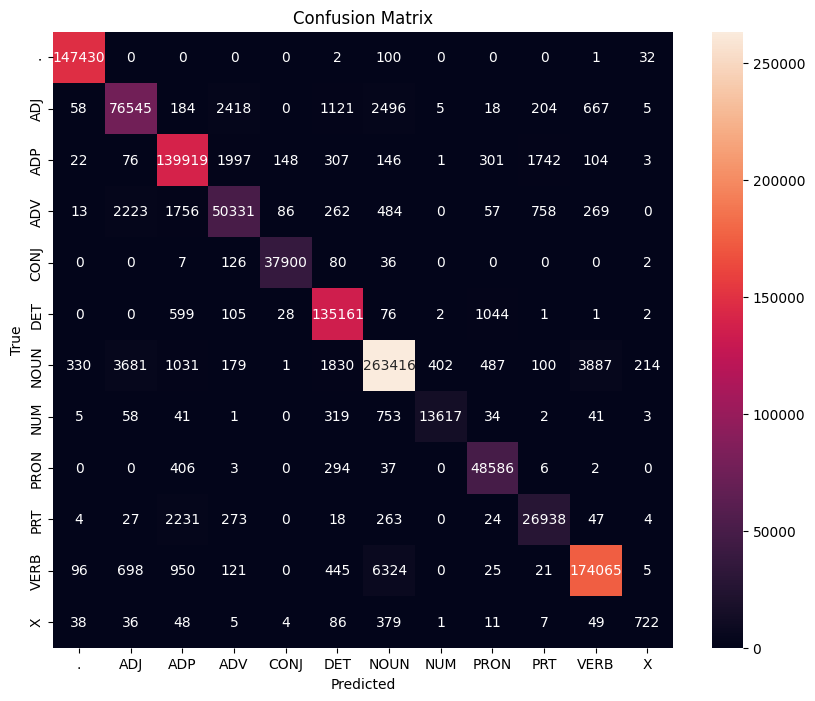

Accuracy for DET: 0.99
Accuracy for NOUN: 0.96
Accuracy for VERB: 0.95
Accuracy for PRON: 0.98
Accuracy for ADP: 0.97
Accuracy for ADJ: 0.91
Accuracy for CONJ: 0.99
Accuracy for .: 1.00
Accuracy for ADV: 0.89
Accuracy for NUM: 0.92
Accuracy for PRT: 0.90
Accuracy for X: 0.52


{'DET': 0.9864398368109533,
 'NOUN': 0.9559366812068603,
 'VERB': 0.9524760601915184,
 'PRON': 0.9848380427291523,
 'ADP': 0.9665183813878949,
 'ADJ': 0.9142867380943849,
 'CONJ': 0.9934208801866268,
 '.': 0.9990851489174262,
 'ADV': 0.8949483454542222,
 'NUM': 0.9154901169826543,
 'PRT': 0.9030808944315935,
 'X': 0.5209235209235209}

<Figure size 640x480 with 0 Axes>

In [52]:
eval.plot_eval()

In [97]:
model = HiddenMarkovModel()
model.train(dataset)
model.save()

In [83]:
print(per_pos.keys())

dict_keys(['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X'])


## Benchmarking against ChatGPT

In [103]:
from nltk.corpus import treebank
nltk.download('treebank')

benchmark_dataset = list(treebank.tagged_sents(tagset='universal'))

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [104]:
benchmark_dataset = [preprocess_sentence(sentence) for sentence in dataset]

In [165]:
for i in benchmark_dataset[720:730]:
    print(len(i), ' '.join([k[0] for k in i]))
    print()

# 720, 721,

20 in the 1920 presidential election they had that right and many of them did vote for the first time .

3 seats on square

34 along this avenue which saw marching soldiers from the war between the states returning in 1865 is the national archives building where hundreds of thousands of this country's most valuable records are kept .

20 also the department of justice building is located where j. edgar hoover presides over the federal bureau of investigation .

17 street car tracks run down the center of pennsylvania , powered with lines that are underground .

18 many spectators will be occupying seats and vantage points bordering lafayette square , opposite the white house .

32 in this historic square are several statues , but the one that stands out over the others is that of gen. andrew jackson , hero of the battle of new orleans .

17 moving past the presidential viewing stand and lafayette square will be at least 40 marching units .

18 about 16,000 military members of all branc

In [188]:
print(benchmark_dataset[725])

[('many', 'ADJ'), ('spectators', 'NOUN'), ('will', 'VERB'), ('be', 'VERB'), ('occupying', 'VERB'), ('seats', 'NOUN'), ('and', 'CONJ'), ('vantage', 'NOUN'), ('points', 'NOUN'), ('bordering', 'VERB'), ('lafayette', 'NOUN'), ('square', 'NOUN'), (',', '.'), ('opposite', 'ADP'), ('the', 'DET'), ('white', 'ADJ'), ('house', 'NOUN'), ('.', '.')]


In [185]:
chatgpt_preds = [
    ['ADP', 'DET', 'NUM', 'NOUN', 'NOUN', 'PRON', 'VERB', 'DET', 'NOUN', 'CONJ', 'ADJ', 'DET', 'PRON', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', '.'],
    ['NOUN', 'ADP', 'NOUN'],
    ['ADP', 'DET', 'NOUN', 'PRON', 'VERB', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NUM', 'VERB', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'PRON', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', '.'],
    ['ADV', 'DET', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'PRON', 'NOUN', 'NOUN', 'VERB', 'ADP', 'DET', 'ADJ', 'NOUN', 'ADP', 'NOUN', '.'],
    ['NOUN', 'NOUN', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'ADJ', 'NOUN', 'ADJ', 'ADJ', '.'],
    ['ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'NOUN', 'CONJ', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'NOUN', '.'],
    ['ADP', 'DET', 'ADJ', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'NOUN', 'PRT', 'DET', 'NUM', 'NOUN', 'PRON', 'VERB', 'ADV', 'ADP', 'DET', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADJ', 'NOUN', 'PRT', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'NOUN', 'NOUN', 'ADJ', '.'],
    ["VERB", "ADP", "DET", "ADJ", "NOUN", "NOUN", "CONJ", "NOUN", "NOUN", "VERB", "VERB", "ADP", "ADV", "NUM", "VERB", "NOUN", "."],
    ["ADP", "NUM", "ADJ", "NOUN", "ADP", "DET", "NOUN", "ADP", "DET", "ADJ", "NOUN", "VERB", "VERB", "NOUN", "ADP", "DET", "NOUN", "."],
    ['NOUN', 'NUM', 'ADP', 'DET', 'NOUN', 'VERB', 'VERB', 'DET', 'ADJ', 'NOUN', '.']
]

for i in range(720,730):
    if len(benchmark_dataset[i]) != len(chatgpt_preds[i-720]):
        print(i, len(benchmark_dataset[i]), len(chatgpt_preds[i-720]))

Accuracy: 0.9638821832473308
Precision: 0.95
Recall: 0.96
F1 Score: 0.95


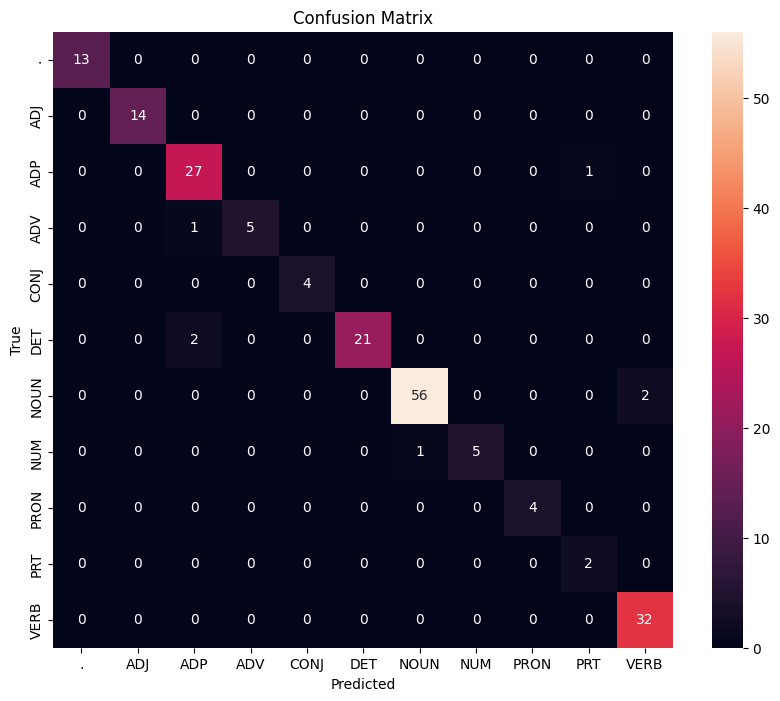

Accuracy for ADP: 0.96
Accuracy for DET: 0.91
Accuracy for NUM: 0.83
Accuracy for ADJ: 1.00
Accuracy for NOUN: 0.97
Accuracy for PRON: 1.00
Accuracy for VERB: 1.00
Accuracy for CONJ: 1.00
Accuracy for .: 1.00
Accuracy for ADV: 0.83
Accuracy for PRT: 1.00


{'ADP': 0.9642857142857143,
 'DET': 0.9130434782608695,
 'NUM': 0.8333333333333334,
 'ADJ': 1.0,
 'NOUN': 0.9655172413793104,
 'PRON': 1.0,
 'VERB': 1.0,
 'CONJ': 1.0,
 '.': 1.0,
 'ADV': 0.8333333333333334,
 'PRT': 1.0}

<Figure size 640x480 with 0 Axes>

In [187]:
model_eval = Evaluation()
print("Accuracy:", model_eval.test_eval(benchmark_dataset[720:730], model))
model_eval.compute_f1()
model_eval.plot_eval()

0.7268854904423978


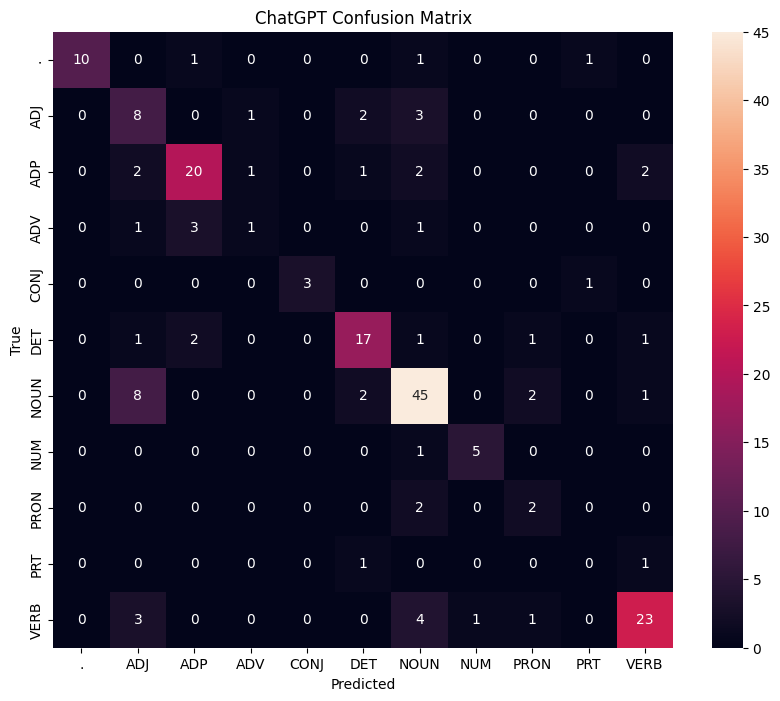

Accuracy for ADP: 0.71
Accuracy for DET: 0.74
Accuracy for NUM: 0.83
Accuracy for ADJ: 0.57
Accuracy for NOUN: 0.78
Accuracy for PRON: 0.50
Accuracy for VERB: 0.72
Accuracy for CONJ: 0.75
Accuracy for .: 0.77
Accuracy for ADV: 0.17
Accuracy for PRT: 0.00


<Figure size 640x480 with 0 Axes>

In [186]:
accuracy = []
confusion_matrix = defaultdict(create_int_defaultdict)
accuracy_per_tag = defaultdict(list)
correct_tagged = 0
total = 0
for i in range(720,730):
    words = [word for word, tag in benchmark_dataset[i]]
    correct_tags = [tag for word, tag in benchmark_dataset[i]]
    predicted_tags = chatgpt_preds[i-720]
    for correct_tag, predicted_tag in zip(correct_tags, predicted_tags):
        if correct_tag == predicted_tag:
            correct_tagged += 1
        confusion_matrix[correct_tag][predicted_tag] += 1
        accuracy_per_tag[correct_tag].append(correct_tag == predicted_tag)
        total += 1
    accuracy.append(correct_tagged/total)
print(np.mean(accuracy))

tags = sorted(confusion_matrix.keys())
matrix = np.array([[confusion_matrix[true_tag][predicted_tag] for predicted_tag in tags] for true_tag in tags])
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt="d", xticklabels=tags, yticklabels=tags)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ChatGPT Confusion Matrix")
plt.show()
plt.savefig("confusion_matrix_plot_chatgpt.png")
tag_accuracies = {tag: np.mean(accuracies) for tag, accuracies in accuracy_per_tag.items()}

for tag, accuracy in tag_accuracies.items():
    print(f"Accuracy for {tag}: {accuracy:.2f}")